In [1]:
#%%
#++++++++++++++++++++++++++++++++++++++++++++++
# Before running the script, edit 
# 'SET HYPERPARAMETERS' 
# - the rest is automated
#++++++++++++++++++++++++++++++++++++++++++++++

##################
### IMPORT MODULES
##################

### System
import sys
import os
from fnmatch import fnmatch 

### I/O
import json
import pickle

### General Processing
import numpy as np
import scipy as sp
import pandas as pd
import networkx as nx
import math
import collections
from collections import OrderedDict
from collections import namedtuple
DottedDict = namedtuple

## DECOMPOSITION
from sklearn.decomposition import NMF
from scipy.linalg import svd
from sklearn.model_selection import train_test_split

### NLU
from ibm_watson import NaturalLanguageUnderstandingV1 as NaLaUn
from ibm_watson.natural_language_understanding_v1 import Features, CategoriesOptions,ConceptsOptions,EntitiesOptions,KeywordsOptions,RelationsOptions,SyntaxOptions

### Presentation / apps
from matplotlib import pyplot as plt
import seaborn as sns

import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
import dash_table.FormatTemplate as FormatTemplate
from dash_table.Format import Sign
from dash.dependencies import Input, Output

import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

## GENERAL FUNCTIONS 

### SELECTION
def random_split(lst,split=0.5):
    shuffled = np.array(lst)
    np.random.shuffle(shuffled)
    split    = int(split * len(shuffled))
    return  shuffled[-split:] , shuffled[:-split]

### NORMALIZATION
#### Statistic normalization - subtract mean, scale by standard deviation
def norm_stat(vec, weights = False):
    '''
    Normalizes a vector v-v.mean())/v.std() 
    '''
    if weights:
        return  np.mean(abs(vec - vec.mean()))  
    return (vec-vec.mean())/vec.std()

#### Algebraic normalization - dot product
def norm_dot(vec, weights = False):
    '''
    Normalizes a vector - dot product: v @ v = 1
    '''
    if weights:
        return  np.sqrt(vec @ vec)
    
    return vec / np.sqrt(vec @ vec)

#### Algebraic normalization - dot product
def norm_sum(vec, weights = False):
    '''
    Normalizes a vector - sum: v.sum = 1
    '''
    if weights:
        return  vec.sum()
    
    return vec / vec.sum()

#### Scaled Normalization -
def scale(vec, weights = False):
    '''
    Normalizes a vector: v.min = 0, v.max = 1
    '''
    stop_divide_by_zero = 0.00000001
    if weights:
        return (vec.max()-vec.min() + stop_divide_by_zero)
    return (vec-vec.min())/(vec.max()-vec.min() + stop_divide_by_zero)
def cleanup_chars(string,char_list = ('\n',' ')):
    result = string
    for char in char_list:
        result = result.replace(char,'')
    return result

### OS system commands

from fnmatch import fnmatch 
def ls(search,name_only = False):
    search_split = search.replace('/','/ ').split()
    pattern      =         search_split[ -1]
    path         = ''.join(search_split[:-1])
    all_names    = np.array(os.listdir(path)) # numpy array enables Boolean Mask
    if not name_only: # add path to each name
        all_names    = np.array([path+name for name in all_names]) 
    mask         = [fnmatch(name,pattern) for name in all_names]
    result       = all_names[mask]
    return result

##########################################
### IBM-WATSON/NLU API-KEY (DON'T EDIT)
##########################################
# The script asks for the API key when run. 
# Do NOT save API-Keys in the code. 

local_dir_exists = os.path.exists('.local')
if not local_dir_exists:
    os.mkdir('.local')
    
credentials_exists = os.path.exists('.local/crd.env')
if not credentials_exists:
    print('Credentials needed for https://cloud.ibm.com/catalog/services/natural-language-understanding )')
    apikey = input(prompt='API-Key?')
    apiurl = input(prompt='API-URL?')
    crd = open('.local/crd.env','w')
    crd.write(  'NATURAL_LANGUAGE_UNDERSTANDING_IAM_APIKEY='+apikey)
    crd.write('\nNATURAL_LANGUAGE_UNDERSTANDING_URL='       +apiurl)  
    

# dian_pkl_file = PATH['results']+'all_dictations_nlu.pkl'  
# dian_pkl_exists = os.path.exists(dian_pkl_file)
# if 'apikey' not in locals():
#     apikey = input(prompt='API-Key? ( https://cloud.ibm.com/catalog/services/natural-language-understanding )')  


# # MATRIX-FACTORIZATION: DIMENSIONALITY REDUCTION & ARCHETYPING

# ## CLUSTER FEATURES INTO OCCUPATION CATEGORIES
# ## Use non-zero matrix factorization for clustering
# ## Use singular value decomposition first state for determining overall similarity

class Archetypes:
    '''
    Archetypes: Performs NMF of order n on X and stores the result as attributes. 
    Archetypes are normalized: cosine similarity a(i) @ a(i) = 1. 
    Atributes:
        my_archetypes.n         - order / number of archetypes
        my_archetypes.X         - input matrix
        
        my_archetypes.model     - NMF model 
        my_archetypes.w         - NMF w-matrix 
        my_archetypes.h         - NMF h-matrix
        
        my_archetypes.o         - occupations x archetypes matrix (from w-matrix)
        my_archetypes.on        - occupations x normalized archetypes matrix (from w-matrix) - SOCP number as index. 
        my_archetypes.occ       - occupations x normalized archetypes matrix - Occupation names as index
        
        my_archetypes.f         - features x archetypes matrix (from h-matrix)
        my_archetypes.fn        - features x normalized archetypes matrix
        
    '''
    
    def __init__(self,X,n,norm = norm_dot,bootstrap = False, bootstrap_frac = 0.5):
        self.n = n
        self.X = X
        self.norm = norm
        
        if bootstrap:
            self.bootstrap_n    = bootstrap
            self.bootstrap_frac = bootstrap_frac
        else:
            self.bootstrap_n    = 1
            self.bootstrap_frac = 1
        
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w_dic = {}
        self.o_dic = {}
        self.h_dic = {}
        self.f_dic = {}   
        
        for j in range(self.bootstrap_n): 
            XX = self.X.sample(int(len(self.X) *self.bootstrap_frac))
            self.w_dic[j] = self.model.fit_transform(XX)
            self.o_dic[j] = pd.DataFrame(self.w_dic[j],index=XX.index)
            self.h_dic[j] = self.model.components_
            self.f_dic[j] = pd.DataFrame(self.h_dic[j],columns=XX.columns)
        
        self.w = self.w_dic[0]  # TEMPORARY
        self.o = self.o_dic[0]  # TEMPORARY
        self.h = self.h_dic[0]  # TEMPORARY
        self.f = self.f_dic[0]  # TEMPORARY

        self.plot_occupations_dic ={}
        self.plot_features_dic ={}
        
#     def test_split(self, split = 0.5):
#         xr = self.X.copy()
#         np.random.shuffle(xr)
#         part = int(len(xr)*split)
#         result = {'train':xr[:len(xr)-part],'test': xr[-part:] }
#         self.X_train = result['train']
#         self.X_test  = result['test' ]
#         return result

    def plot_features(self,fig_scale = (1,3.5),metric='cosine', method = 'single',vertical = False): 
        '''
        Plot Archetypes as x and features as y. 
        Utilizes Seaborn Clustermap, with hierarchical clustering along both axes. 
        This clusters features and archetypes in a way that visualizes similarities and diffferences
        between the archetypes. 
        
        Archetypes are normalized (cosine-similarity): dot product archetype[i] @ archetype[i] = 1.
        The plot shows intensities (= squared feature coefficients) so that the sum of intensities = 1.  

        fig_scale: default values (x/1, y/3.5) scales the axes so that all feature labels are included in the plot.
        
        For other hyperparameters, see seaborn.clustermap
     
        '''
        param = (fig_scale,metric,method,vertical)
        if param in self.plot_features_dic.keys():
            fig = self.plot_features_dic[param]
            return fig.fig

        df = np.square(self.fn)

        if vertical:
            fig = sns.clustermap(df.T,robust = True, z_score=1,figsize=(
                self.n/fig_scale[0],self.X.shape[1]/fig_scale[1]),method = method,metric = metric)        
        else: # horizontal
            fig = sns.clustermap(df,robust = True, z_score=0,figsize=(
                self.X.shape[1]/fig_scale[1],self.n/fig_scale[0]),method = method,metric = metric)        
        self.features_plot = fig
        return fig


    def plot_occupations(self,fig_scale = (1,3.5),metric='cosine', method = 'single',vertical = False):
        '''
        Plot Archetypes as x and occupations as y. 
        Utilizes Seaborn Clustermap, with hierarchical clustering along both axes. 
        This clusters occupations and archetypes in a way that visualizes similarities and diffferences
        between the archetypes. 
        
        Occupations are normalized (cosine-similarity): dot product occupation[i] @ occupation[i] = 1.
        The plot shows intensities (= squared feature coefficients) so that the sum of intensities = 1.  

        fig_scale: default values (x/1, y/3.5) scales the axes so that all feature labels are included in the plot.
        
        For other hyperparameters, see seaborn.clustermap
     
        '''
        param = (fig_scale,metric,method,vertical)
        if param in self.plot_occupations_dic.keys():
            fig = self.plot_occupations_dic[param]
            #return
            return fig.fig

        df = np.square(self.occ)
        if vertical:
            fig = sns.clustermap(df, figsize=(
                self.n/fig_scale[0],self.X.shape[0]/fig_scale[1]),method = method,metric = metric)
        else: # horizontal
            fig = sns.clustermap(df.T, figsize=(
                self.X.shape[0]/fig_scale[1],self.n/fig_scale[0]),method = method,metric = metric)
        self.plot_occupations_dic[param] = fig
        #return
        return fig.fig


class Svd:
    ''''
    Singular value decomposition-as-an-object
        my_svd = Svd(X) returns
        my_svd.u/.s/.vt – U S and VT from the Singular Value Decomposition (see manual)
        my_svd.f        – Pandas.DataFrame: f=original features x svd_features
        my_svd.o        - Pandas.DataFrame: o=occupations x svd_features
        my_svd.volume(keep_volume) 
                        - collections.namedtuple ('dotted dicionary'): 
                          Dimensionality reduction. keeps 'keep_volume' of total variance
                          
                          
    '''
    def __init__(self,X):
        self.u,self.s,self.vt = svd(np.array(X))
        self.f = pd.DataFrame(self.vt,columns=X.columns)
        self.o = pd.DataFrame(self.u,columns=X.index)
        
    def volume(self,keep_volume):
        ''' 
        Dimensionality reduction, keeps 'keep_volume' proportion of original variance
        Type: collections.namedtuple ('dotted dictionary')
        Examples of usage:
        my_svd.volume(0.9).s - np.array: eigenvalues for 90% variance 
        my_svd.volume(0.8).f - dataframe: features for 80% variance
        my_svd.volume(0.5).o - dataframe: occupations for 50% variance      
        '''
        dotted_dic = collections.namedtuple('dotted_dic', 's f o')
        a1 = self.s.cumsum()
        a2 = a1/a1[-1]
        n_max = np.argmin(np.square(a2 - keep_volume))
        cut_dic = dotted_dic(s= self.s[:n_max],f= self.f.iloc[:n_max], o= self.o.iloc[:n_max])
        return cut_dic
        

##########################
## SET HYPERPARAMATERS
#### edit below ##########

# Import credentials
cred = open('.local/crd.env','r').read()
apikey,apiurl = cred.replace('NATURAL_LANGUAGE_UNDERSTANDING_IAM_APIKEY=','').replace(
                            'NATURAL_LANGUAGE_UNDERSTANDING_URL=','').split()

PATH = {}
PATH['data']    = '../data/Documents/'
PATH['results'] = './Watson-nlu-results/'

NLU = {}
NLU['apikey']         = apikey
NLU['apiurl']         = apiurl
NLU['version']        = '2019-07-12'
NLU['features']       = Features(
                        categories= CategoriesOptions(),
                        concepts  = ConceptsOptions(),
                        entities  = EntitiesOptions(),
                        keywords  = KeywordsOptions(),
                        relations = RelationsOptions(),
                        syntax    = SyntaxOptions()
                        )


class DocumentArchetypes:
    '''
    DocumentArchetypes performs Archetypal Analysis on a corpus consisting of a set of documents, for example a set 
    of articles, books, news stories or medical dictations.
    
    Input parameters:
    
    PATH            - Dictionary with paths to I/O
    PATH['data']    - Directory for input text files. Example: './data/input_texts/'
    PATH['results'] - Directory for output.           Example: './data/output_nlu/'
    
    NLU                   - Dictionary with information for running Watson NLU
    NLU['apikey']         - apikey for running Watson NLU
    NLU['apiurl']         - URL for Watson NLU API
    NLU['version']        - Watson NLU version, e.g. '2019-07-12'
    NLU['features']       - Features requested from Watson NLU for each document in the set, e.g. 
                                Features(
                                categories= CategoriesOptions(),
                                concepts  = ConceptsOptions(),
                                entities  = EntitiesOptions(),
                                keywords  = KeywordsOptions(),
                                relations = RelationsOptions(),
                                syntax    = SyntaxOptions()
                                )

    Attributes:

        
        self.PATH 
    
        
    '''
    from ibm_watson import NaturalLanguageUnderstandingV1 as NaLaUn
    from ibm_watson.natural_language_understanding_v1 import Features, CategoriesOptions,ConceptsOptions,EntitiesOptions,KeywordsOptions,RelationsOptions,SyntaxOptions
    
    def __init__(self, PATH, NLU, train_test = False):
        self.PATH       = PATH
        self.NLU        = NLU
        self.train_test = train_test
        
        self.nlu_model  = NaLaUn(version=NLU['version'] , iam_apikey = NLU['apikey'], url = NLU['apiurl'])  #Local Natural Language Understanding object
        self.archetypes_dic = {}
       
 
        ################
        ## PREPARE DATA 
        ################
        self.filenames = ls(self.PATH['data']+'*.txt', name_only=True)  # all filenames ending with '.txt' 
        self.names     = [name.replace('.txt','') for name in self.filenames]
        self.all_names = self.names *1      # if train_test - self.names will be set to self.names_train
        self.dictation_dic = {}             # dictionary for dictation files
        for name in self.filenames:
            self.dictation_dic[name.replace('.txt','')] = open(self.PATH['data']+name).read()
        self.dictation_df = pd.Series(self.dictation_dic)
            
        ####################
        ## TRAIN-TEST SPLIT 
        ####################
        if self.train_test: # 0<train_test<1 - the proportion of names to save as 'test (rounded downwards)
            self.names_test , self.names_train = random_split(self.all_names , self.train_test)
            self.names = self.names_train

        ###############################
        ## PERFORM WATSON NLU ANALYSIS
        ###############################
        
        self.watson = {}    #Dictionary with Watson-NLU results for each dictation
        
        self.watson_pkl = PATH['results']+'all_dictations_nlu.pkl'  
        pkl_exists = os.path.exists(self.watson_pkl)

        if pkl_exists:
            self.watson = pickle.load( open( self.watson_pkl, "rb" ) )

        else: #perform nlu-analysis on dictations
            for item in list(self.dictation_dic.items()):
                lbl  = item[0]
                text = item[1]
                self.watson[lbl] = self.nlu_model.analyze(text = text, features=NLU['features'])
                f = open(PATH['results']+str(lbl)+'_nlu.pkl','wb')
                pickle.dump(self.watson[lbl],f)
                f.close()

            f = open(self.watson_pkl,'wb')
            pickle.dump(self.watson,f)
            f.close() 

        # Copy Watson NLU results to Pandas Dataframes
        self.watson_nlu = {}
        for dctn in self.watson.items():
            self.watson_nlu[dctn[0]] = {}
            for item in list(dctn[1].result.items()):
                self.watson_nlu[dctn[0]][item[0]]=pd.DataFrame(list(item[1]))


    ##############
    # ARCHETYPAL ANALYSIS
    ##############
    
    ### FIX FIX FIX FIX  self.X_matrix[_train/_test] should be dictionary, FIX FIX FIX FIX ###
    
    def build_x_matrix(self,typ='entities'):
        if typ not in self.archetypes_dic.keys():
            self.archetypes_dic[typ] = {}
        df = pd.DataFrame()
        for key in self.names:
            dfx = self.watson_nlu[key][typ].copy()
            dfx['dictation'] = key
            df = df.append(dfx,sort=True)
        if typ is 'entities':
            df = df[df['type']=='HealthCondition']
            df.rename({'relevance': 'rel0'}, axis=1,inplace=True)
            df['relevance'] = df['rel0'] * df['confidence']
        self.X_matrix = df.pivot_table(index='dictation',columns='text',values='relevance').fillna(0)
        
        if self.train_test:
            self.X_matrix_train = self.X_matrix
            
            df = pd.DataFrame()
            for key in self.names_test:
                dfx = self.watson_nlu[key][typ].copy()
                dfx['dictation'] = key
                df = df.append(dfx,sort=True)
            if typ is 'entities':
                df = df[df['type']=='HealthCondition']
                df.rename({'relevance': 'rel0'}, axis=1,inplace=True)
                df['relevance'] = df['rel0'] * df['confidence']
            self.X_matrix_test = df.pivot_table(index='dictation',columns='text',values='relevance').fillna(0)


        

    def archetypes(self,typ='entities',n_archs=6,bootstrap = False, bootstrap_frac = 0.5):
        hyperparam = (n_archs,bootstrap,bootstrap_frac)
        self.build_x_matrix(typ)
        self.archetypes_dic[typ][hyperparam] = Archetypes(self.X_matrix,n_archs,bootstrap = bootstrap, bootstrap_frac = bootstrap_frac)
        return self.archetypes_dic[typ][hyperparam]


    def display_archetype(self,display_variable = -1, typ = 'entities' , n_archs = 6, var = 'variables', threshold = 0.1):
        fun = {'variables' : 'self.archetypes(typ = typ,n_archs = n_archs).f.apply(scale).T ',
               'dictations': 'self.archetypes(typ = typ,n_archs = n_archs).o.T.apply(scale)'
               }
        if display_variable == -1:
            return sns.clustermap(eval(fun[var])).data2d
        else:
            arc = eval(fun[var]).sort_values(by=display_variable,ascending = False)
            result = arc[
                        arc[display_variable] >= (threshold * arc[display_variable][0])
                        ]
            return result
        
        
        def arch_map(self,vector, var = 'dictation', typ = 'entities'):
            
            
            
    
    



  
  

In [2]:
dan = DocumentArchetypes(PATH,NLU,train_test = 0.05)

In [82]:
dan.archetypes(n_archs = 5, typ = 'entities')

In [85]:

bas = dan.archetypes().f.T.apply(norm_dot)
vec = dan.X_matrix_test.loc[['130']]




,0,1,2,3,4,5
text,,,,,,
ARDS,0.002743,0.000000,0.000263,0.000000,0.000000,0.000000
Allergies,0.007700,0.004520,0.004434,0.000000,0.000000,0.000000
Allergies allergies,0.000000,0.000000,0.004939,0.002979,0.000542,0.000000
Alzheimer,0.000000,0.000000,0.000000,0.000000,0.122840,0.000000
Anemia,0.000000,0.000000,0.000000,0.000000,0.023663,0.000000
Anorexia,0.000000,0.000000,0.000000,0.000000,0.046258,0.010524
Atrial fibrillation,0.000000,0.000000,0.000947,0.001172,0.000000,0.000000
Bipolar disorder,0.000845,0.000000,0.000000,0.000000,0.000752,0.000000
Blood pressure,0.001433,0.002304,0.006773,0.000000,0.000000,0.006855


In [5]:
dan.watson_nlu['31']['keywords']

,count,relevance,text
0,1,0.901393,Assessment Number
1,1,0.802961,Labs labs WBC
2,1,0.607121,Past medical history
3,1,0.598464,nonweightbearing status
4,3,0.591953,diabetic neuropathy
5,1,0.579313,atherosclerotic coronary artery disease
6,4,0.578258,mg b
7,2,0.574370,diabetes mellitus type
8,2,0.573670,breast cancer
9,2,0.570378,Functional status


In [55]:
ff = dan.archetypes(typ='entities').f
ff 

text,ARDS,Allergies,Allergies allergies,Alzheimer,Anemia,Anorexia,Atrial fibrillation,Bipolar disorder,Blood pressure,Blood pressure 1 blood pressure,...,vascular,vascular disease,vascular encephalopathy,vein thrombosis,ventricular hypertrophy,vertigo,vitamin D deficiency,vomiting,wheezing,wrist fracture
0,0.006647,0.018660,0.000000,0.000000,0.00000,0.000000,0.000000,0.002048,0.003472,0.006802,...,0.000000,0.002890,0.000000,0.001901,0.000000,0.000000,0.000000,0.00000,0.000000,0.019958
1,0.000000,0.014434,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.007358,0.000000,...,0.005026,0.000000,0.000605,0.000000,0.022775,0.000000,0.004941,0.00000,0.010280,0.000000
2,0.000606,0.010239,0.011404,0.000000,0.00000,0.000000,0.002187,0.000000,0.015641,0.000668,...,0.000000,0.000000,0.004029,0.003860,0.000000,0.010404,0.000000,0.00000,0.001542,0.000000
3,0.000000,0.000000,0.007169,0.000000,0.00000,0.000000,0.002819,0.000000,0.000000,0.000000,...,0.000000,0.010266,0.000000,0.000000,0.000000,0.000000,0.000025,0.92829,0.002989,0.000000
4,0.000000,0.000000,0.001751,0.396706,0.07642,0.149387,0.000000,0.002429,0.000000,0.000000,...,0.064686,0.004591,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.00000,0.039407,0.000000,0.000000,0.025667,0.003293,...,0.000000,0.034591,0.000000,0.000000,0.000000,0.024031,0.000000,0.00000,0.000000,0.004653


In [62]:
dsv = Svd(dan.X_matrix)
dsv.f 
ft = ff @ dsv.f.T
ftn = ft.apply(norm_dot,axis = 1)
ftn @ ftn.T

,0,1,2,3,4,5
0,1.000000,0.071813,0.076487,0.030093,0.036675,0.049875
1,0.071813,1.000000,0.178336,0.043595,0.130966,0.013088
2,0.076487,0.178336,1.000000,0.166313,0.148760,0.032269
3,0.030093,0.043595,0.166313,1.000000,0.033800,0.045466
4,0.036675,0.130966,0.148760,0.033800,1.000000,0.044584
5,0.049875,0.013088,0.032269,0.045466,0.044584,1.000000


In [65]:
ffn = ff.apply(norm_dot,axis = 1)
ffn @ ffn.T

,0,1,2,3,4,5
0,1.000000,0.071813,0.076487,0.030093,0.036675,0.049875
1,0.071813,1.000000,0.178336,0.043595,0.130966,0.013088
2,0.076487,0.178336,1.000000,0.166313,0.148760,0.032269
3,0.030093,0.043595,0.166313,1.000000,0.033800,0.045466
4,0.036675,0.130966,0.148760,0.033800,1.000000,0.044584
5,0.049875,0.013088,0.032269,0.045466,0.044584,1.000000


In [51]:
dsv.volume(0.8).o

dictation,1,10,100,101,102,103,104,105,106,107,...,90,91,92,93,94,95,96,97,98,99
0,0.007610,-0.003736,0.003061,-0.000246,0.003893,-0.011186,0.013173,-0.006841,0.004026,-0.033075,...,0.000495,2.598632e-03,0.000170,0.003389,0.001005,0.000008,0.000449,0.000024,2.028700e-18,-2.556512e-18
1,0.043727,-0.007285,0.045216,-0.024199,0.023574,0.037773,0.071128,-0.021592,-0.013142,-0.087873,...,-0.007354,-3.105182e-02,0.008549,0.010882,0.004261,-0.001573,-0.002664,0.001212,2.580080e-16,-3.283370e-16
2,0.028587,-0.082928,-0.123839,0.079872,0.107930,0.031470,0.004446,0.004451,0.013791,-0.014565,...,-0.004778,1.399044e-02,0.034807,-0.000789,-0.001382,0.002405,0.000565,0.000485,-5.360398e-16,6.794650e-16
3,0.037916,-0.061018,-0.139702,0.095371,0.107347,0.013935,0.012932,-0.001120,0.015599,-0.005160,...,0.085691,-5.072334e-01,0.090704,0.050351,0.137494,0.023600,-0.029130,-0.016745,-1.325973e-15,-2.443813e-15
4,0.009510,-0.036750,-0.048894,0.023537,0.037378,0.003780,0.003850,-0.013172,-0.001089,0.015650,...,-0.192801,-4.630231e-01,0.058759,-0.626842,-0.240025,-0.014995,-0.081723,0.000521,-4.467997e-16,-7.197379e-17
5,0.024992,-0.025603,0.005107,0.014632,-0.001769,0.028738,-0.024773,0.009837,-0.031113,0.019245,...,-0.052464,-5.450875e-02,-0.094704,0.042067,-0.019495,-0.002746,-0.013435,0.005940,3.695607e-17,3.950472e-17
6,0.051692,-0.101920,-0.194464,-0.087954,-0.091130,-0.012451,0.033230,-0.020705,-0.120724,0.069814,...,-0.001006,6.953904e-04,-0.001317,-0.000001,-0.000744,-0.000238,0.000216,-0.000027,3.760200e-17,-1.333704e-16
7,0.031316,-0.042833,-0.044128,0.048221,0.045941,0.067771,-0.004240,0.027718,0.025921,-0.031154,...,0.018011,7.871303e-03,-0.003098,-0.000614,-0.003921,-0.001936,-0.001452,-0.000012,-2.695015e-16,-1.381589e-16
8,0.018945,-0.061088,-0.076749,0.045835,0.068734,0.013396,-0.013112,-0.031463,-0.005515,0.030896,...,0.018875,3.089198e-02,0.064883,-0.019267,0.016728,0.016689,0.001734,0.000502,1.077631e-17,3.672241e-16
9,0.030646,-0.038639,-0.030406,0.058429,0.039267,0.013525,-0.010469,0.086710,-0.011072,-0.037975,...,0.013806,6.603142e-03,-0.001283,-0.002662,-0.000414,0.000302,-0.001122,-0.000150,-5.760766e-16,6.563249e-16


In [13]:
aaa = dan.watson['31']
aaa.

In [6]:
dan.display_archetype(1,n_archs = 6, var = 'variables', typ='keywords')

,0,1,2,3,4,5
text,,,,,,
Next number,0.000000,1.000000,0.027872,0.000000,0.018673,0.000000
atrial fibrillation,0.000000,1.000000,0.667832,0.263196,0.000000,0.127761
chest pain,0.000000,1.000000,0.555380,0.083794,0.507861,0.000590
coronary artery disease,0.196901,1.000000,0.838008,0.525362,0.000000,0.165716
bipolar disorder,0.000000,1.000000,0.000000,0.000000,0.353441,0.020430
ejection fraction,0.000000,1.000000,0.500199,0.297961,0.000000,0.000000
emergency room,0.000000,1.000000,0.000000,0.000000,0.000000,0.255776
Next number parkinsonism,0.000000,1.000000,0.000000,0.000000,0.000000,0.085962
cyanosis of extremities,0.000000,1.000000,0.000000,0.000000,0.134668,0.264745


In [7]:
dan.archetypes_dic

{}

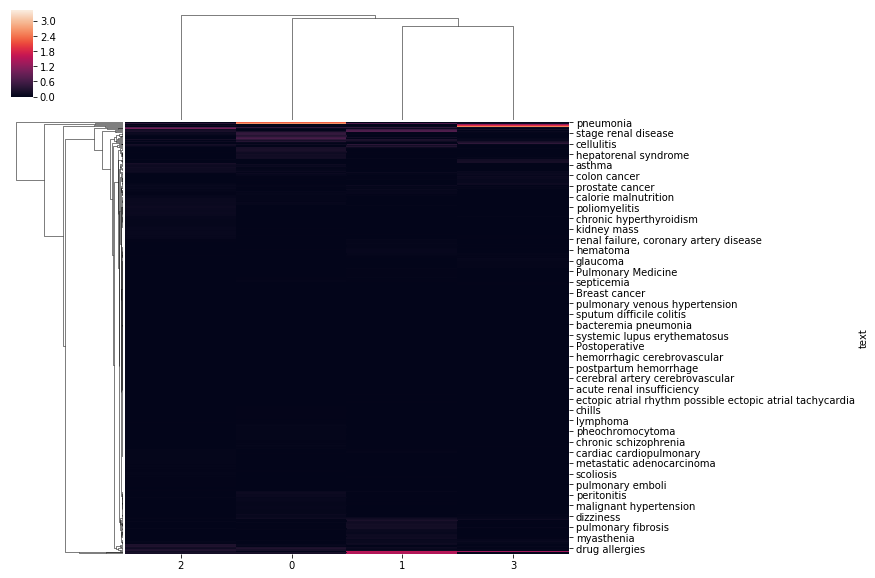

In [73]:
bbb = sum(list(aan_f2.values()))


In [13]:
aaa.f_dic[19]

text,ARDS,Addison's disease,Allergies,Allergies allergies,Alzheimer,Anemia,Anorexia,Atrial fibrillation,Bipolar disorder,Blood pressure,...,vascular disease,vascular encephalopathy,vein thrombosis,venous stasis ulcers,ventricular hypertrophy,vertigo,vitamin D deficiency,vomiting,wheezing,wrist fracture
0,0.0,0.0,0.010383,0.000000,0.000000,0.000000,0.0,0.005952,0.000000,0.000000,...,0.000000,0.009513,0.000000,0.000000,0.000000,0.000000,0.000000,0.503468,0.000000,0.000000
1,0.0,0.0,0.006326,0.000000,0.002151,0.000000,0.0,0.002463,0.000000,0.006763,...,0.000000,0.000000,0.000036,0.000000,0.012592,0.000000,0.002308,0.014187,0.006384,0.000299
2,0.0,0.0,0.007825,0.000000,0.000000,0.000000,0.0,0.000000,0.002704,0.002014,...,0.044732,0.000000,0.003506,0.021047,0.000000,0.000000,0.000000,0.000000,0.000000,0.029130
3,0.0,0.0,0.008649,0.040823,0.000000,0.000000,0.0,0.021483,0.000000,0.039754,...,0.074257,0.002592,0.000292,0.031230,0.001512,0.033706,0.000000,0.000000,0.006215,0.002429
4,0.0,0.0,0.011783,0.000204,0.375287,0.099865,0.0,0.000000,0.005066,0.000000,...,0.005192,0.000000,0.000000,0.000000,0.000000,0.000000,0.001497,0.000000,0.000000,0.000000
5,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.019832,0.000000,0.034356,...,0.008167,0.000000,0.000669,0.000000,0.000000,0.028706,0.000000,0.000000,0.000000,0.005557


In [15]:
bbb = Archetypes(aaa.X.sample(int(len(aaa.X) * 0.5)),n = 4,bootstrap = 3)

In [18]:
bbb.f_dic[0]

text,ARDS,Addison's disease,Allergies,Allergies allergies,Alzheimer,Anemia,Anorexia,Atrial fibrillation,Bipolar disorder,Blood pressure,...,vascular disease,vascular encephalopathy,vein thrombosis,venous stasis ulcers,ventricular hypertrophy,vertigo,vitamin D deficiency,vomiting,wheezing,wrist fracture
0,0.0,0.000000,0.010016,0.0,0.030597,0.001021,0.000000,0.0,0.000000,0.022069,...,0.000000,0.010431,0.008057,0.0,0.000692,0.0,0.000000,0.315666,0.010134,0.0
1,0.0,0.042954,0.030940,0.0,0.000000,0.000000,0.000000,0.0,0.001266,0.001886,...,0.000000,0.001491,0.002558,0.0,0.022592,0.0,0.004529,0.000000,0.006283,0.0
2,0.0,0.000000,0.013981,0.0,0.000000,0.002846,0.000000,0.0,0.005417,0.022366,...,0.010209,0.000000,0.000000,0.0,0.000000,0.0,0.000888,0.000000,0.000000,0.0
3,0.0,0.000000,0.000000,0.0,0.108204,0.000000,0.286721,0.0,0.000399,0.033614,...,0.053020,0.000000,0.000000,0.0,0.000000,0.0,0.000112,0.000000,0.000000,0.0


In [5]:
def aan_f(n, norm = norm_dot):
    return aaa.f_dic[n].apply(norm ,axis=1)

In [11]:
aan_f(0) @ aan_f(4).T

,0,1,2,3,4,5
0,0.120850,0.857378,0.010989,0.026977,0.031320,0.042162
1,0.198595,0.120076,0.152541,0.170870,0.693620,0.014290
2,0.314641,0.143054,0.714048,0.196883,0.116123,0.020757
3,0.933741,0.130758,0.081501,0.182153,0.182466,0.030357
4,0.215727,0.058093,0.079556,0.863137,0.355179,0.043402
5,0.059641,0.051887,0.036742,0.118665,0.049422,0.978636


/anaconda3/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning:

Use the colorbar set_ticks() method instead.



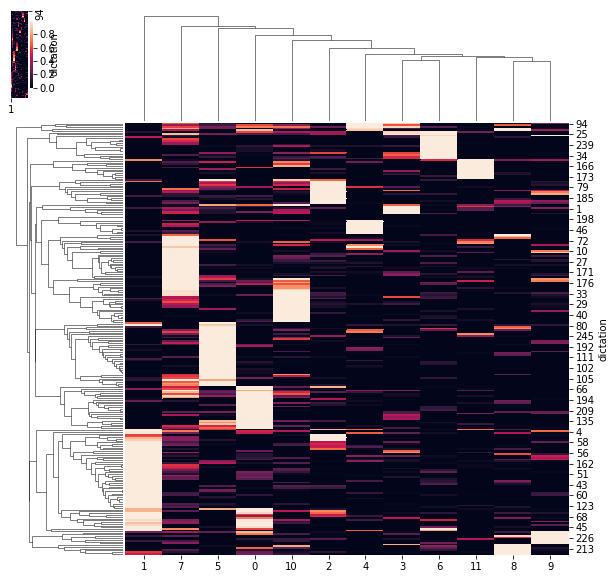

In [27]:
sns.heatmap(sns.clustermap(archetypes(typ='entities',n_archs=12).o.apply(scale, axis = 1)).data2d.apply(norm_sum,axis=1))

In [6]:
arcs = archetypes(typ='entities',n_archs=12)
len_X = len(arcs.X) 
arcs.X.sample(len_X//2)

AttributeError: 'Archetypes' object has no attribute 'w'

In [ ]:
1+1